# Details of Distributing a Dask Cluster Between Data Centres

## Introduction

This show the details of the proof of concept. It follows on from [dask-multi-cloud.ipynb](./dask-multi-cloud.ipynb)

## Architecture

This is how the system looks when it is running

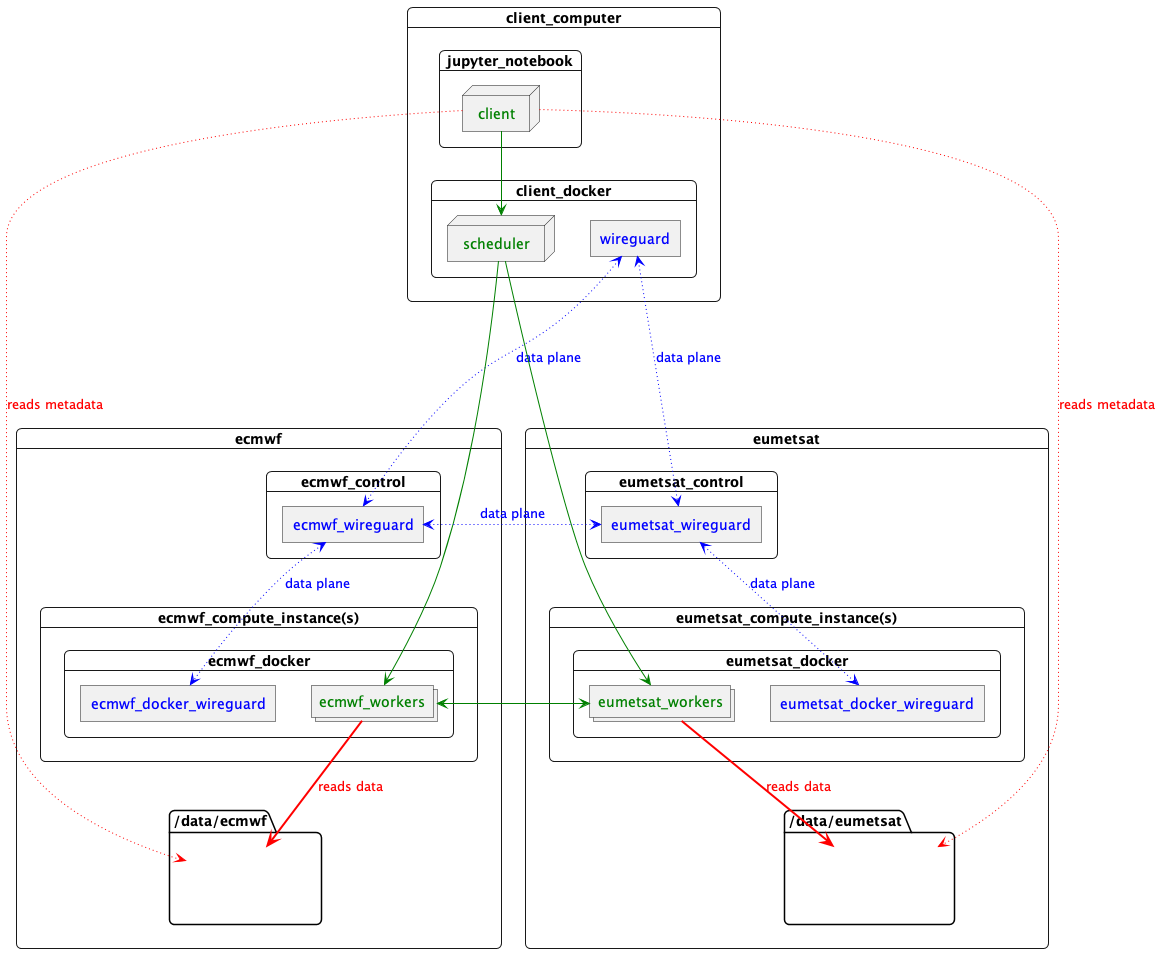

In [1]:
from IPython.display import Image
from rendering import *
from IPython.display import HTML as show

Image(filename="images/datacentres-dask.png")

Key

* <span style='color: blue'>Data plane network</span>
* <span style='color: green'>Dask</span>
* <span style='color: red'>NetCDF data</span>

Once running, we have a Dask scheduler hosted on the client computer, talking to multiple Dask workers hosted on (potentially) multiple compute instances in multiple data centres. The Dask processes are all hosted in Docker containers that live only for the life of the cluster. 

Data plane networking once the cluster has been established is provided by an WireGuard IPv6 network. A single control plane node in each data centre (`ecmwf_control` and `eumetsat_control`) acts as a router for data plane traffic between locations, minimising the number of public addresses required whilst still allowing all Dask worker processes to connect to each other and the scheduler, but is not strictly necessary.

This architecture could be implemented with different technologies. For the demonstrator the compute instances are pre-provisioned VMs in their respective data centres. Setup and control is implemented in Python and Bash, with SSH and pre-shared keys used to run processes on remote machines. Our aim wasn't to produce a production system, but to show that this could be done at all.

Bearing that in mind, let's see how this is implemented and run up.

## Data Plane Network

The data plane network is a two-layer mesh. A single WireGuard process runs on a single control node in each data centre.  In combination with the scheduler, these form a fully-connected mesh.  Each control node acts as a router for traffic to and from the workers hosted in that data center, which are in a star-configuration under the router.  The router concept simplifies the full-mesh part of the network and, as the router and its workers sit in a single data center, avoids potential addressing/accessibility issues.

We use [private IPv6 addresses](https://en.wikipedia.org/wiki/Unique_local_address) in the VPN. This allows us to avoid clashes with IPv4 private ranges, which are mostly all committed and potentially overlapping in different data centers.  It also permits a very simple and fixed address structure:

`<static_private_component>:<site_id>:<node id>`

* static = `fda5:c0ff:eeee`
* site id: 0 = scheduler, 1 = site 1, 2 = site 2, etc
* node id: 1 = router or scheduler, 11 = worker 1, 12 = worker 2, etc

Examples:
*  `fda5:c0ff:eeee:0::1`  = always the scheduler IP
*  `fda5:c0ff:eeee:1::1`  = router on site 1
*  `fda5:c0ff:eeee:3::12` = worker 2 on site 3


## Implementation

We start the cluster thus

```bash
./dask-boot.sh controluser@%ECMWF_HOST controluser%EUMETSAT_HOST
```

### dask-boot.sh

`dask-boot.sh` starts up the cluster. To do this it runs a Python script inside a Docker container on the local computer. The container forwards Dask control ports to `localhost` and enables some IPv6 capabilities.

In [2]:
show(render_sh('../dask_multicloud/dask-boot.sh'))

### spawn_multi_cloud_dask.py

The script run in the container is the heart of the operation - `spawn_multi_cloud_dask.py`.

It

1. Generates the keys and configuration to create a mesh WireGuard IPv6 data plane network, with one control node in each data centre. 
2. Starts a WireGuard interface using this network in its container
3. Starts a Dask scheduler process in its container. This will use the data plane network, and be accessible on the host computer.
4. Starts up worker nodes in each location by running a (preconfigured) script on the control nodes over SSH on the control plane network.

In [3]:
show(render_py('../dask_multicloud/docker/spawn_multi_cloud_dask.py'))

### wg_cloud_gateway.sh

`wg_cloud_gateway.sh` is the script run on each of the control node machines over SSH. They have been pre-configured with the script, and with a trusted SSH public key to allow us to make the connection and run the script as sudo. 

`spawn_multi_cloud_dask.py` passes `wg_cloud_gateway.sh` details of the the other control node network addresses. That script then  brings up a WireGuard network connected to the scheduler node and the other control nodes, then starts worker processes in Docker containers.

In [4]:
show(render_sh('../dask_multicloud/dask_wg/wg_cloud_gateway.sh'))

Hidden in that blur of Bash is the detail that our demonstrator doesn't actually implement the architecture as we envision it. Instead of the control node commisioning workers on separate hosts, it runs workers in Docker containers on the same instance. This is a simplification for the proof of concept (which mainly concerns itself with whether the networking is working) but limits the amount of CPU that can be brought to bear on a calculation.

A more realistic system would have an equivalent of `wg_cloud_gateway.sh` as a control node endpoint hosted in a Kubernetes cluster, and able to bring up and manage pods to run the workers for this cluster.

Moving on, we have the script run in each worker Docker container.

### worker_with_wireguard.sh

The worker Docker containers are configured with the Python libraries required to run Dask and the required computation.

They also need a WireGuard interface created on the data plane network before they start the Dask worker, so that it can connect back to the scheduler.

In [5]:
show(render_sh('../dask_multicloud/docker/worker_with_wireguard.sh'))

Note that this is the point that the `POOL_NAME` is provided to label the workers. This is passed in from `wg_cloud_gateway.sh`, which fetches it from a `DASK_POOL_NAME` environment variable set in `/etc/environment` on the control node computer.

The standard `dask-worker` script is used to start the workers. On a multi-core machine this will start more than one worker process, each listening on a different port, but sharing the same data plane network address. The virtual network allows incoming connections to aribitrary ports without having to configure the host machines and routers in the data centre.

### Dockerfile

For simplicity we use the same Docker image to start both the scheduler and worker containers. It is based on miniconda3, with WireGuard and some network debugging packages.

`spawn_multi_cloud_dask.py` connects to the control nodes by SSH - the private key it uses is built into the image.

In [6]:
show(render_sh('../dask_multicloud/docker/Dockerfile'))

This image has the minimum Python environment required to run Dask distributed

In [7]:
show(render_sh('../dask_multicloud/docker/environment.yml'))

We deploy the image from `Dockerfile` as `dmcg/wireguard_scheduler` - the one used in `start-cluster.sh`. To do actual computations we use it to build another image with the required data processing libraries - this is `dmcg/irisxarray`, composed of

In [8]:
show(render_sh('docker/irisxarray/Dockerfile'))

and

In [9]:
show(render_sh('irisxarray-environment.yml'))

(The duplication in the libraries is because we also use this file to build the environment for the Jupyter notebook acting as client for the cluster.)

### Control Node Configuration

The following Ansible playbook, showing the configuration of a worker in EUMETSAT, should give some pointers. Note that this is for a combined control node and compute instance, so needs to be split into the two roles. Note also to that when it refers to `wireguard base network` this is our control plane network, not the IPv6 data plane network set up for the cluster. 

In [10]:
show(render_sh('../dask_multicloud/ansible/eumetsat-worker-playbook.yml'))

## Future Work

### File Access

Data for this demo is held in NetCDF files, and so we have had to mount them in a block filesystem. Zarr would allow the data to be stored in object storage accessible over HTTP, hence removed the need for NFS mounting and potentially the separate control plane network.

Alternately, network file system shares and mounts could be created as part of the cluster, and the traffic routed over the data plane network.

### Provisioning Workers

The proof of concept system has a single worker machine in each cluster, hosting Dask worker processes and a data plane network adapter in a Docker container. The control process (eg ecmwf_control in the diagram) runs on this worker machine.

A more scaleable solution would be to use a Kubernetes cluster or eg AWS Fargate to provision multiple compute instances. In this case the WireGuard interface in the control node acts a data plane router between all the nodes in one data centre and other data centres.

_Crown Copyright 2022_